Jupyter notebook accompanying the manuscript "Non-negligible impact of Stokes drift and wave-driven Eulerian currents on simulated surface particle dispersal in the Mediterranean Sea" by Rühs et al., adapted from https://github.com/immerse-project/Downstream-Users-Toolbox/tree/main/T8.3_WaveCoupling_ParticleTransport_UniU
- Author: Siren Rühs (s.ruhs@uu.nl)
- Created: Dec 6th 2022
- Last updated: Mar 25th 2024

# Calculating Lagrangian trajectories from ocean-only (uncoupled)  and ocean-wave (coupled) model simulations for the MedSea

## 0. Getting Started

- Make sure you read the general README.md and - as described there - installed miniconda and required packages (including parcels), and got access to the underlying model data
- Carefully check and eventually adjust the parameters and path information in section 2 if necessary
- For a first check whether set-up is working, execute the notebook with release_name in 2.2 set to "Test"
-  To obtain the full four sets of trajectories evaluated in the Eval-Traj* notebooks, run this notebook for each release_name ("GulfOfLion", "SubReg9", and "SubReg14") 4 times, with key_input in 2.1 changing from (i) "uncoupled" to (ii) "uncoupled_sd", (iii)"coupled_sd", and (iv) "coupled_nosd"


## 1. General Settings

Can nearly always stay untouched

### 1.1 Load modules and check versions

In [1]:
from glob import glob
from datetime import timedelta, datetime
import math

from parcels import (FieldSet, ParticleSet,
                     JITParticle, ScipyParticle,
                     AdvectionRK4,
                     Variable, Field, VectorField)
import xarray as xr
import numpy as np

%matplotlib inline

In [2]:
# modified after: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
# make sure to use Parcels version 2.4.0 or later for zarr output

import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        yield name


imports = list(set(get_imports()))
# get the version of the root package from only the name of the package
# via cross-checking the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))
for r in requirements:
    print("{}=={}".format(*r))

xarray==2022.12.0
parcels==2.4.0
numpy==1.24.1



### 1.2 Define general custom functions


In [3]:
# DEFINE ALTERNATIVE TO USE NP.ARANGE
#
# from https://stackoverflow.com/questions/50299172/python-range-or-numpy-arange-with-end-limit-include
# (code posted by Markus Dutschke on Aug 2nd 2019, last accessed on Dec 6th 2023)
#
# WHY using it?
# In principal, values are generated within the half-open interval [start, stop)
# (in other words, the interval including start but excluding stop).
# Yet, unfortunately, when using a non-integer step (such as 0.1),
# the results of np.arange are often not consistent.
# Specifically, they sometimes do include the stop value.
# It is better to use the following function based on numpy.linspace for these cases

def cust_range(*args, rtol=1e-05, atol=1e-08, include=[True, False]):
    """
    Combines numpy.arange and numpy.isclose to mimic
    open, half-open and closed intervals.
    Avoids also floating point rounding errors as with
    >>> numpy.arange(1, 1.3, 0.1)
    array([1. , 1.1, 1.2, 1.3])

    args: [start, ]stop, [step, ]
        as in numpy.arange
    rtol, atol: floats
        floating point tolerance as in numpy.isclose
    include: boolean list-like, length 2
        if start and end point are included
    """
    # process arguments
    if len(args) == 1:
        start = 0
        stop = args[0]
        step = 1
    elif len(args) == 2:
        start, stop = args
        step = 1
    else:
        assert len(args) == 3
        start, stop, step = tuple(args)

    # determine number of segments
    n = (stop-start)/step + 1

    # do rounding for n
    if np.isclose(n, np.round(n), rtol=rtol, atol=atol):
        n = np.round(n)

    # correct for start/end is exluded
    if not include[0]:
        n -= 1
        start += step
    if not include[1]:
        n -= 1
        stop -= step

    return np.linspace(start, stop, int(n))


def crange(*args, **kwargs):
    return cust_range(*args, **kwargs, include=[True, True])


def orange(*args, **kwargs):
    return cust_range(*args, **kwargs, include=[True, False])


print("crange(1, 1.3, 0.1) >>>", crange(1, 1.3, 0.1))
print("orange(1, 1.3, 0.1) >>>", orange(1, 1.3, 0.1))
print("crange(0.0, 0.6, 0.2) >>>", crange(0.0, 0.6, 0.2))
print("orange(0.0, 0.6, 0.2) >>>", orange(0.0, 0.6, 0.2))

crange(1, 1.3, 0.1) >>> [1.  1.1 1.2 1.3]
orange(1, 1.3, 0.1) >>> [1.  1.1 1.2]
crange(0.0, 0.6, 0.2) >>> [0.  0.2 0.4 0.6]
orange(0.0, 0.6, 0.2) >>> [0.  0.2 0.4]


## 2. Custom settings Parcels
!!! IMPORTANT: need to be checked/adjusted before every execution !!! Particularly check the parts highlighted within lines of #### !!!

### 2.1 Define input paths


In [4]:
############################

# set key to 'uncoupled', 'uncoupled_sd', 'coupled_nosd', or 'coupled_sd'
key_input = 'uncoupled'

# define whether ocean velocity is sampled (key_sample_velocity = True)
key_sample_velocity = True

############################

# path were original surface velocity putput is stored
datapath = '../data-orig/'

# path were model grid info is stored
gridpath = ('../data-proc/domain/fgrid.nc')

if (key_input == 'uncoupled') or (key_input == 'uncoupled_sd'):
    filepaths_u = sorted(glob(
        datapath + 'MedFS-IMMERSE-NEMO4p2-uncoupled_gridUV-z001/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(
        datapath + 'MedFS-IMMERSE-NEMO4p2-uncoupled_gridUV-z001/MED24_OBC_1d*_grid_V.nc'))
    if key_input == 'uncoupled':
        key_stokes = False
        print('calculate trajectories for uncoupled simulation without additional consideration of Stokes drift')
    elif key_input == 'uncoupled_sd':
        key_stokes = True
        filepaths_usd = sorted(glob(
            datapath + 'MedFS-IMMERSE-NEMO4p2-coupled_gridUV-z001/MED24_OBC_1d*_grid_U.nc'))
        filepaths_vsd = sorted(glob(
            datapath + 'MedFS-IMMERSE-NEMO4p2-coupled_gridUV-z001/MED24_OBC_1d*_grid_V.nc'))
        print('calculate trajectories for uncoupled simulation without additional consideration of Stokes drift')

elif (key_input == 'coupled_nosd') or (key_input == 'coupled_sd'):
    filepaths_u = sorted(glob(
        datapath + 'MedFS-IMMERSE-NEMO4p2-coupled_gridUV-z001/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(
        datapath + 'MedFS-IMMERSE-NEMO4p2-coupled_gridUV-z001/MED24_OBC_1d*_grid_V.nc'))
    if key_input == 'coupled_nosd':
        key_stokes = False
        print('calculate trajectories for coupled simulation without explicit consideration of Stokes drift')
    elif key_input == 'coupled_sd':
        key_stokes = True
        filepaths_usd = filepaths_u
        filepaths_vsd = filepaths_v
        print('calculate trajectories for coupled simulation with explicit consideration of Stokes drift')

else:
    print('no (valid) key_input defined')

calculate trajectories for uncoupled simulation without additional consideration of Stokes drift


###  2.2 Define Particle release grid

In [5]:
############################

# set release name
# - 'GulfOfLion', 'SubReg9', 'SubReg14' (particles released every 5 days over one year), or
# - 'Test' (particles released over one time step only)
release_name = 'Test'

############################


# time step of input data in seconds (here: daily)
times_convert = 86400

# first release time step referenced to start of input data set
# (use time step of input data set, here: daily)
tstart_release = 0

# continous release every deltat_release time steps
# (use time step of input data set, here: daily,
# release each time from the same set of locations)
deltat_release = 5

# final release time step referenced to start of input data set
# (use time step of input data set, here: daily)
if release_name == "Test":
    tend_release = 5
else:
    tend_release = 365

# definition of release areas
# Gulf of Lion
if (release_name == 'GulfOfLion') or (release_name == 'Test'):
    lonmin = 3
    lonmax = 5.6
    latmin = 42.1
    latmax = 43.5
    step = 0.05  # (appr. every grid cell)
# Ionian Sea: subregion 9
if release_name == 'SubReg9':
    lonmin = 15.0
    lonmax = 17.0
    latmin = 36.1
    latmax = 38.1
    step = 0.05  # (appr. every grid cell)
# Gulf of Antalya: subregion 14
if release_name == 'SubReg14':
    lonmin = 30.3
    lonmax = 32.3
    latmin = 35
    latmax = 37
    step = 0.05  # (appr. every grid cell)

lons, lats = np.meshgrid(crange(lonmin, lonmax, step),
                         crange(latmin, latmax, step))
n_releasepos = lons.shape[0]*lons.shape[1]
n_particles = n_releasepos * ((tend_release-tstart_release)/deltat_release)
print("maximum number of release positions (including land):", n_releasepos)
print("maximum number of particles (including land):", int(n_particles))

maximum number of release positions (including land): 1537
maximum number of particles (including land): 1537


### 2.3 Define Lagrangian trajectory integration parameters


In [6]:
# total integration time in days
tint = 30

# integration time step in minutes
deltat = 25
# How to chose deltat? Follow Schmidt et al. (2021):
# The time step dt should be small enough that particles do not skip grid cells
# and thereby miss characteristic oceanographic features.
# Due to trade-off between accuracy of time stepping and computation time, the integration
# time step dt was chosen such that particles stay in one model grid cell for at least 2dt
# Therefore, a time step dt can be calculated following dt<dsmin/(vmax⋅2)
# where dsmin is the smallest edge of all grid cells in the domain and
# vmax is the largest horizontal velocity.
# assume vmax = 1m/s, dsmin = 1/24 = 3000 m : dt < (3000 / 2)s = 1500 s = 25 min
# (at 45N - northern boundary MedSea - 1deg lon is appr. 79km -> 1/24 deg = 3300m;
# 1 deg lat is 111km)

# particle class
# can be JITParticle or ScipyParticle
# (if possible use JITParticle)
pclass = JITParticle

### 2.4 Define Lagrangian trajectory output

In [7]:
############################

# set frequency with which to output particle data
# (in days)
outdt = 1

############################

procpath = '../data-proc/traj/' + release_name +'/'
! mkdir -p $procpath #creates output folder if it does not exist yet

if key_input == 'uncoupled':
    outpath = (procpath + 'Parcels_CalcTraj_Data-uncoupled_Release-' + release_name)
if key_input == 'uncoupled_sd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-uncoupled-sd_Release-' + release_name)
elif key_input == 'coupled_nosd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-' + release_name)
elif key_input == 'coupled_sd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-coupled-sd_Release-' + release_name)

## 3. Execution of parcels simulation

### 3.1 Create custom Parcels functions

In [8]:
def create_fieldset(keystokes=False):

    filenames = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_u},
                 'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_v}}
    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}}
    fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                                  mesh='spherical',
                                  allow_time_extrapolation=False,
                                  time_periodic=False)

    if keystokes == True:
        filenames_sd = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_usd},
                        'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_vsd}}
        variables_sd = {'U': 'usd',
                        'V': 'vsd'}
        fieldset_sd = FieldSet.from_nemo(filenames_sd, variables_sd, dimensions,
                                         mesh='spherical',
                                         allow_time_extrapolation=False,
                                         time_periodic=False)
        fieldset_sum = FieldSet(U=fieldset.U+fieldset_sd.U,
                                V=fieldset.V+fieldset_sd.V)
        fieldset_use = fieldset_sum
    elif keystokes == False:
        fieldset_use = fieldset

    return fieldset_use



Kernels partially adopted and modified from https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts


In [9]:
class BeachParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=2)

In [10]:
class BeachCurrentParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=0)
    U = Variable('U', dtype=np.float32, initial=0)
    V = Variable('V', dtype=np.float32, initial=0)

In [11]:
def AdvectionRK4(particle, fieldset, time):
    if particle.beached == 0:
        (u1, v1) = fieldset.UV[time,
                               particle.depth, particle.lat, particle.lon]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt,
                      particle.lat + v1*.5*particle.dt)

        (u2, v2) = fieldset.UV[time + .5 *
                               particle.dt, particle.depth, lat1, lon1]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt,
                      particle.lat + v2*.5*particle.dt)

        (u3, v3) = fieldset.UV[time + .5 *
                               particle.dt, particle.depth, lat2, lon2]
        lon3, lat3 = (particle.lon + u3*particle.dt,
                      particle.lat + v3*particle.dt)

        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle.beached = 2

In [12]:
def SampleUV(particle, fieldset, time):
    # attention: samples particle velocity in deg/s and needs to be converted to m/s
    # also note that fieldset is sampled at time+particle.dt, as first advection
    # is performed and positions are updated, then fieldset is sampled at new location
    # and time+dt, then time is updated
    # this procedure will probably not be necessary with future parcel releases
    particle.U, particle.V = fieldset.UV[particle.time +
                                         particle.dt, particle.depth, particle.lat, particle.lon]

In [13]:
def BeachTesting(particle, fieldset, time):
    if particle.beached == 2:
        (u, v) = fieldset.UV[particle.time+particle.dt,
                             particle.depth, particle.lat, particle.lon]
        # if velocity threshold ist set to 1e-8 (suggestion Christian) artificial beaching occurs
        # -> do NOT do that
        if math.fabs(u) < 1e-14 and math.fabs(v) < 1e-14:
            particle.beached = 1
            print("Particle [%d] beached !! (%g %g %g %g)" % (
                particle.id, particle.lon, particle.lat, particle.depth, particle.time+particle.dt))
        else:
            particle.beached = 0

In [14]:
def BeachTesting_initial(particle, fieldset, time):
    if particle.beached == 2:
        (u, v) = fieldset.UV[particle.time,
                             particle.depth, particle.lat, particle.lon]
        # if velocity threshold ist set to 1e-8 (suggestion Christian) artificial beaching occurs
        # -> do NOT do that
        if math.fabs(u) < 1e-14 and math.fabs(v) < 1e-14:
            particle.beached = 1
            print("Particle [%d] beached !! (%g %g %g %g)" % (
                particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        else:
            particle.beached = 0

In [15]:
def DeleteParticle(particle, fieldset, time):
    if particle.beached == 1:
        particle.delete()
        print("Particle [%d] deleted !! (%g %g %g %g)" % (
            particle.id, particle.lon, particle.lat, particle.depth, particle.time))

In [16]:
def PlotParticleSet(pset, fieldset):
    plotstep = 4
    pset.show(field=fieldset.U,
              domain={'N': (latmax+plotstep/2), 'S': (latmin-plotstep),
                      'E': (lonmax+plotstep), 'W': (lonmin-plotstep)})

In [17]:
def PlotParticleSet(pset, fieldset):
    plotstep = 2
    # for larger values velocity field will be sampled out of bounds
    # due to our chosen release regions
    pset.show(field=fieldset.U,
              domain={'N': (latmax+plotstep), 'S': (latmin-plotstep),
                      'E': (lonmax+plotstep), 'W': (lonmin-plotstep)})

### 3.2 Determine exact particle release positions (mask land positions)

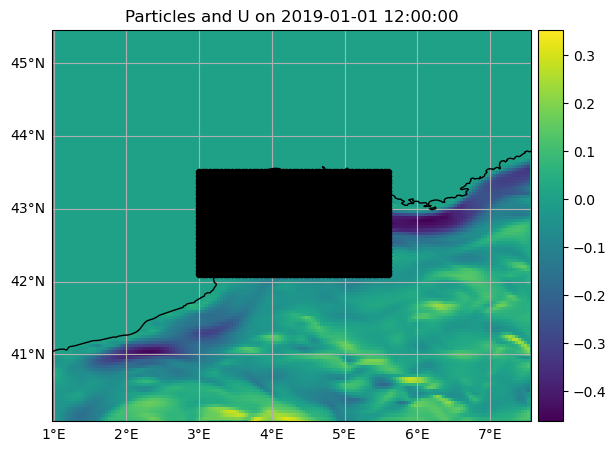

maximum number of release positions (including land): 1537



INFO: Compiled ArrayBeachParticleBeachTesting_initialDeleteParticle ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib34807ea9a005db1720b8d67817d066f6_0.so
/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/matplotlib/colors.py:719: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


Particle [0] beached !! (3 42.1 0 0)
Particle [1] beached !! (3.05 42.1 0 0)
Particle [2] beached !! (3.1 42.1 0 0)
Particle [3] beached !! (3.15 42.1 0 0)
Particle [53] beached !! (3 42.15 0 0)
Particle [54] beached !! (3.05 42.15 0 0)
Particle [55] beached !! (3.1 42.15 0 0)
Particle [106] beached !! (3 42.2 0 0)
Particle [107] beached !! (3.05 42.2 0 0)
Particle [108] beached !! (3.1 42.2 0 0)
Particle [159] beached !! (3 42.25 0 0)
Particle [160] beached !! (3.05 42.25 0 0)
Particle [161] beached !! (3.1 42.25 0 0)
Particle [212] beached !! (3 42.3 0 0)
Particle [213] beached !! (3.05 42.3 0 0)
Particle [214] beached !! (3.1 42.3 0 0)
Particle [215] beached !! (3.15 42.3 0 0)
Particle [216] beached !! (3.2 42.3 0 0)
Particle [217] beached !! (3.25 42.3 0 0)
Particle [218] beached !! (3.3 42.3 0 0)
Particle [265] beached !! (3 42.35 0 0)
Particle [266] beached !! (3.05 42.35 0 0)
Particle [267] beached !! (3.1 42.35 0 0)
Particle [268] beached !! (3.15 42.35 0 0)
Particle [318] beac

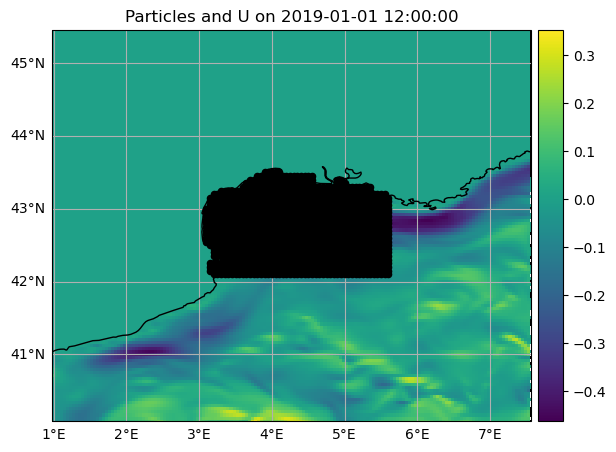

actual number of release positions (excluding land): 1291
actual number of particles: 1291.0


In [18]:
# release particles on predefined uniform grid, including land grid points
fieldset_init = create_fieldset(keystokes=False)
pset_init = ParticleSet(fieldset=fieldset_init,
                        pclass=BeachParticle,
                        lon=lons, lat=lats, time=0)
pset_init.populate_indices()
PlotParticleSet(pset_init, fieldset_init)
print('maximum number of release positions (including land):', pset_init.lon.size)
print()
lons_prelim = pset_init.lon
lats_prelim = pset_init.lat

# perform a "fake" integration to determine and delete particles released on land
# by making use of beach-testing and deleting kernels
# (without advection kernel)
kernels_init = pset_init.Kernel(
    BeachTesting_initial) + pset_init.Kernel(DeleteParticle)
pset_init.execute(kernels_init, dt=0)
PlotParticleSet(pset_init, fieldset_init)

# retrieve lon and lats from all ocean release positions
print("actual number of release positions (excluding land):", pset_init.lon.size)
print("actual number of particles:",
      pset_init.lon.size * ((tend_release-tstart_release)/deltat_release))
lons_use = pset_init.lon
lats_use = pset_init.lat

### 3.3 Perform trajectory integration and save trajectories in .zarr format

In [19]:
%%time
for times in range(tstart_release, tend_release, deltat_release):
    
    if (key_sample_velocity == True):
        pclass_main = BeachCurrentParticle
        outpath_ending = "m_Sample-UV.zarr"
    else:
        pclass_main=BeachParticle
        outpath_ending = "m.zarr"
  
    # create new clean particle set (including new clean fieldset)
    # ensure that for each release date the particle numbering starts again from 0
    fieldset_main = create_fieldset(keystokes=key_stokes)
    BeachCurrentParticle.setLastID(0)
    BeachParticle.setLastID(0)
    pset_main = ParticleSet(fieldset=fieldset_main,
                            pclass=pclass_main,
                            lon=lons_use, lat=lats_use,
                            time=times*times_convert)   
    pset_main.populate_indices()
    
    # define output
    # ensure depth is not stored in trajectory output
    # (depth not necessary for 2D calculations)
    pset_main.set_variable_write_status("depth", False) 
    outpath_final = (outpath + "-t" + str(times) 
                     + "_Integrate-fw-d" + str(tint) + "-dt" + str(deltat) 
                     + outpath_ending)
    outfile_final = pset_main.ParticleFile(outpath_final, 
                                           outputdt=timedelta(days=outdt))
  
    # advect particle
    # do not delete potentially beached particles, but keep them for statistics
    if (key_sample_velocity == True):
        kernels_main = (pset_main.Kernel(AdvectionRK4) + pset_main.Kernel(BeachTesting) 
                        + pset_main.Kernel(SampleUV))
    else:
        kernels_main = (pset_main.Kernel(AdvectionRK4) + pset_main.Kernel(BeachTesting))
    pset_main.execute(kernels_main,
                      runtime=timedelta(days=tint),
                      dt=timedelta(minutes=deltat),
                      output_file=outfile_final)
    
    pset_main.set_variable_write_status("depth", True)
    # somehow needed, otherwise next pset can not be build


INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/libf3cdcb2ae818c046d2c55bb3cccb1a65_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [149] beached !! (3.10417 42.25 0 950400)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

CPU times: user 31.9 s, sys: 3.36 s, total: 35.2 s
Wall time: 39.1 s


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


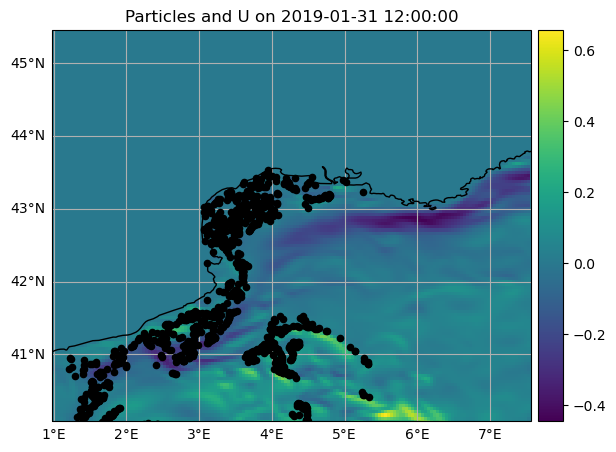

In [20]:
# plot final positions 
## in this simple form only works for uncoupled simulation
## as Parcels plotting routine can not deal with summed fieldsets
PlotParticleSet(pset_main,fieldset_main)